# Ensemble average of probabilities from various models
## of test time augmented probabilies 

# Lib imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Data_path = '/content/drive/MyDrive/Colab Notebooks/FinalProject/Visual-1/'
Data_path + 'resnet50_places_progressive_resizing/val_probs_tta.csv'

'/content/drive/MyDrive/Colab Notebooks/FinalProject/Visual-1/resnet50_places_progressive_resizing/val_probs_tta.csv'

# Load data probability files with all test time augmented validations

In [4]:
# Resnet 50 places 365
rn50_plc_val_df = pd.read_csv(Data_path + 'resnet50_places_progressive_resizing/val_probs_tta.csv')
rn50_plc_val_df.name = 'Resnet 50 places 365'

# Imagenet resnet 50
rn50_val_df = pd.read_csv(Data_path + 'resnet_50_progressive_resizing/val_probs_tta.csv')
rn50_val_df.name ='Imagenet resnet 50'

# Imagenet resnet 101
rn101_val_df = pd.read_csv(Data_path + 'resnet_101/val_probs_tta.csv')
rn101_val_df.name ='Imagenet resnet 101'

# Imagenet resnext 101-next 
sernxt_val_df = pd.read_csv(Data_path + 'se_resnext101/val_probs_tta.csv')
sernxt_val_df.name ='Imagenet resnext 101-next'


In [5]:
print('\n\033[1m >>', rn50_plc_val_df.name); display(rn50_plc_val_df.head())
print('\n\033[1m >>', rn50_val_df.name); display(rn50_val_df.head())
print('\n\033[1m >>', rn101_val_df.name); display(rn101_val_df.head())
print('\n\033[1m >>', sernxt_val_df.name); display(rn50_val_df.head())


 >> Resnet 50 places 365


,buildings,forest,glacier,mountain,sea,street,image_name,ground_label
0,6.737539e-04,1.044293e-07,4.317101e-07,5.271999e-07,7.753595e-07,9.993244e-01,16525.jpg,5
1,5.736681e-05,1.484929e-04,7.533726e-01,8.374138e-04,2.455225e-01,6.171868e-05,13651.jpg,2
2,9.999834e-01,1.151890e-07,2.106648e-06,5.109700e-07,4.915793e-07,1.337738e-05,13383.jpg,0
3,9.999737e-01,4.519182e-07,1.811936e-06,3.891489e-07,2.139658e-06,2.166839e-05,11483.jpg,0
4,3.318392e-07,5.853170e-07,3.124403e-05,7.521308e-06,9.999603e-01,7.762713e-08,19306.jpg,4



 >> Imagenet resnet 50


,buildings,forest,glacier,mountain,sea,street,image_name,ground_label
0,2.867854e-04,1.109198e-07,4.753775e-07,6.784446e-07,0.000001,9.997107e-01,16525.jpg,5
1,3.549014e-06,3.466793e-06,9.981116e-01,1.817996e-04,0.001692,7.849612e-06,13651.jpg,2
2,9.994719e-01,5.298385e-07,1.016252e-05,8.807727e-06,0.000008,5.007012e-04,13383.jpg,0
3,9.999152e-01,4.103639e-07,3.410274e-06,1.052877e-06,0.000002,7.768787e-05,11483.jpg,0
4,8.912550e-07,3.554716e-07,7.994288e-06,9.838146e-05,0.999892,7.592143e-07,19306.jpg,4



 >> Imagenet resnet 101


,buildings,forest,glacier,mountain,sea,street,image_name,ground_label
0,9.092325e-04,2.183200e-06,5.706530e-06,7.388077e-07,0.000007,9.990754e-01,16525.jpg,5
1,5.602316e-06,8.353445e-06,9.971453e-01,6.419359e-04,0.002160,3.872834e-05,13651.jpg,2
2,9.999123e-01,5.121162e-07,1.681185e-06,2.146707e-07,0.000002,8.385084e-05,13383.jpg,0
3,9.999747e-01,1.062802e-06,9.028997e-07,4.206092e-08,0.000002,2.139099e-05,11483.jpg,0
4,9.372312e-07,1.565652e-06,7.620794e-05,5.744162e-05,0.999864,4.221686e-07,19306.jpg,4



 >> Imagenet resnext 101-next


,buildings,forest,glacier,mountain,sea,street,image_name,ground_label
0,2.867854e-04,1.109198e-07,4.753775e-07,6.784446e-07,0.000001,9.997107e-01,16525.jpg,5
1,3.549014e-06,3.466793e-06,9.981116e-01,1.817996e-04,0.001692,7.849612e-06,13651.jpg,2
2,9.994719e-01,5.298385e-07,1.016252e-05,8.807727e-06,0.000008,5.007012e-04,13383.jpg,0
3,9.999152e-01,4.103639e-07,3.410274e-06,1.052877e-06,0.000002,7.768787e-05,11483.jpg,0
4,8.912550e-07,3.554716e-07,7.994288e-06,9.838146e-05,0.999892,7.592143e-07,19306.jpg,4


# Ensembling

In [6]:
# rn50_plc_val_df.columns
label_cols = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
rn101_val_df.columns

Index(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street',
       'image_name', 'ground_label'],
      dtype='object')

In [7]:
# ground label for validation set
val_ground_labels = rn101_val_df['ground_label'].values
rn101_val_df['ground_label'].shape

(3407,)

In [8]:
# add all probs 
val_all_sum = rn101_val_df[label_cols].values + rn50_val_df[label_cols].values + rn50_plc_val_df[label_cols].values + sernxt_val_df[label_cols].values
val_all_sum.shape

(3407, 6)

In [9]:
val_pred = val_all_sum.argmax(1)

In [10]:
# Check accuracy for valiadtion set
accuracy_score(y_true=val_ground_labels, y_pred=val_pred)

0.9545054299970649

## validation set accuracy > 

# Plot Confusion matrix

In [11]:
label_mapper = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

In [12]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

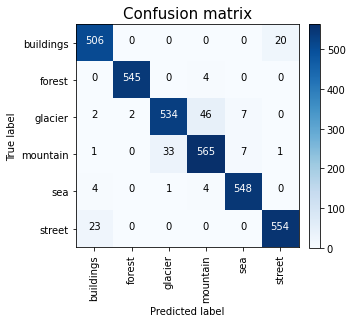

In [13]:
plot_confusion_matrix(pd.Series(val_ground_labels).map(label_mapper), pd.Series(val_pred).map(label_mapper), label_cols)

# Load augmented test time data probability files.

In [15]:
# resnet 50 places 365
rn50_plc_test_df = pd.read_csv(Data_path + 'resnet50_places_progressive_resizing/test_probs_tta.csv')

# Imagenet resnet 50
rn50_test_df = pd.read_csv(Data_path + 'resnet_50_progressive_resizing/test_probs_tta.csv')

# Imagenet resnet 101
rn101_test_df = pd.read_csv(Data_path + 'resnet_101/test_probs_tta.csv')

# Imagenet resnext 101 
sernxt_test_df = pd.read_csv(Data_path + 'se_resnext101/test_probs_tta.csv')

In [16]:
# add probabilities
test_all_sum = rn101_test_df[label_cols].values + rn50_test_df[label_cols].values + rn50_plc_test_df[label_cols].values + sernxt_test_df[label_cols].values

In [17]:
# image file names
test_img_names = rn101_test_df['image_name'].values

In [18]:
# make a submission
pd.DataFrame({'image_name': test_img_names, 'label': test_all_sum.argmax(1)}).to_csv('sub.csv', index=False)